<div class="alert alert-block alert-info">
    <b>Projet 5 | Segmentez des clients d'un site e-commerce<br></b>
    <p style="color:#8B0000;">
        Partie 1 |  Analyse Exploratoire</p>
</div>

# 1 | Présentation du projet

Je suis consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.

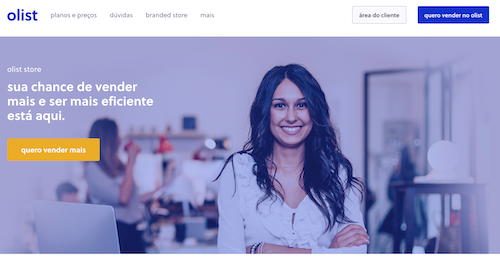

Olist souhaite que fournir à ses équipes d'e-commerce une **segmentation des clients utilisable au quotidien** pour leurs campagnes de communication.<br>
L'objectif est de **différencier les utilisateurs selon leur comportement d'achat** et leurs **données personnelles**.<br>

Il s'agit de fournir une description actionnable de la segmentation et de sa logique, ainsi qu’une proposition de **contrat de maintenance** basée sur une analyse de la **stabilité des segments** au cours du temps.

Pour cette mission, Olist fournit une base de données anonymisée comportant des informations sur l’**historique de commandes**, les **produits achetés**, les **commentaires de satisfaction**, et la **localisation des clients** depuis janvier **2017**.

J'utiliserai des **méthodes non supervisées** pour regrouper des clients de profils similaires. Ces **catégories** pourront être utilisées par **l’équipe Marketing** pour mieux communiquer.

Orientations spécifiques :<br>
-  seuls **3 % des clients** du fichier de données ont réalisé **plusieurs commandes**
-  la segmentation **différenciera les bons et les moins bons** clients en termes de **commandes** et de **satisfaction**
-  la segmentation couvrira l’**ensemble des clients**
-  une recommandation de **fréquence de mise à jour de la segmentation** sera fournie pour un contrat de maintenance
-  respecter la **convention PEP8** pour le code

Ces orientations mènent à explorer tout d'abord une segmentation RFM pour établir à tire de comparaison des segments de clients homogènes selon l'approche classique, avant de poursuivre avec des méthodes de clusterisation non supervisées.<br>

Approche RFM :

-  **Récence** (date de la dernière commande),
-  **Fréquence** des commandes
-  **Montant** (de la dernière commande ou sur une période donnée)

Livrables :
-  Un notebook de l'**analyse exploratoire** (non cleané, pour comprendre ma démarche)
-  Un notebook (ou code commenté au choix) d’essais des différentes **approches de modélisation** (non cleané)
-  Un notebook de **simulation** pour déterminer la **fréquence nécessaire** de **mise à jour** du modèle de segmentation.
-  Un **support de présentation** pour présenter mon travail à un collègue.

# 2 | Import des packages, fonctions et paramétrage initial

Notebook variables reset for each complete execution of this code :

In [621]:
%reset -f

## 2.1 | Fonctions utiles au projet 

In [1]:
def switch_log(columns):
    """Fonction qui remplace par son logarithme chaque
    valeur non négative du jeu de colonnes spécifié
    (en ajoutant 1 afin de considérer 0).
    on conserve les colonnes originales dans data (pas de backup)
    """

    # on passe au log les variables sélectionnées dans columns
    # on conserve la colonne d'origine
    for column in columns:
        col_name = str(column + '_log')
        shift = 1 - data[column].min()
        data[col_name] = data[column].apply(lambda x: np.log(x + shift))


def days_latest(x):
    """returns the number of days since last purchase,
    starting from the day of the last sale - Latest_Date - in the final dataset
    """
    return (Latest_Date - x.max()).days

## 2.2 | Vérification de la version de Python

In [623]:
!python -V

Python 3.7.0


## 2.3 | Installation des nouveaux packages nécessaires

In [624]:
# installing chart_studio
!pip install chart_studio

## 2.4 | Import des packages utiles au projet

In [625]:
# Modules classiques d'analyse exploratoire:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import missingno as msno
import scipy.stats as stats
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj
import re

# Mathématiques
import math

# Manipulation fichiers et Interaction avec l'os / notebook
import os
import csv
import requests
import warnings
import json
import autopep8

# Manipulation de chaines de caractères
# from ast import literal_eval #abstract syntax tree
# from bs4 import BeautifulSoup as soup

# Données géographiques et géométriques
# import geopy
# from geopy.distance import geodesic
# import re
# from geopy.extra.rate_limiter import RateLimiter
# from shapely.geometry import Point
# import folium
# import folium.plugins

# Manipulations temporelles
import datetime as dt
# from tqdm import tqdm
# from tqdm.notebook import tqdm, trange
import time

# Extraction web
# from urllib.request import urlopen as uReq # Web client
# import urllib.request # Web client
# from importlib_metadata import version

# Feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.cluster import KMeans

## 2.5 | Vérification des versions de package disponibles

In [626]:
!pip list

Package                           Version
--------------------------------- ------------
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
attrs                             21.4.0
autopep8                          1.6.0
backcall                          0.2.0
beautifulsoup4                    4.11.1
bleach                            4.1.0
branca                            0.5.0
bs4                               0.0.1
certifi                           2021.10.8
cffi                              1.15.0
charset-normalizer                2.0.12
chart-studio                      1.1.0
colorama                          0.4.4
cycler                            0.11.0
debugpy                           1.5.1
decorator                         5.1.1
defusedxml                        0.7.1
distlib                           0.3.4
entrypoints                       0.4
filelock                          3.6.0
folium                            0.12.1.post1
fonttools      

## 2.6 | Mise en page et réglages divers du notebook

In [627]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour bien visualiser les colonnes
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)

# Affichage avec la bibliothèque graphique intégrée à Notebook:
%matplotlib inline

# Format des graphiques seaborn
sns.set_theme(style="whitegrid")

# 3 | Chargement et préparation des données

## 3.1 | Chargement des DataFrames

In [628]:
# Création des DataFrame
customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
name_translation = pd.read_csv("product_category_name_translation.csv")

In [629]:
# Liste des DataFrame
list_df = ["customers", "geolocation", "items", "payments",
           "reviews", "orders", "products", "sellers", "name_translation"]

Let's take a look at our dataframes. We need to create a database gathering the necessary information so we can apply the RFM clustering method.<br>

Hence we will create first a dataset for the orders, with the following data for each order : 
-  order date (from orders)
-  order amounts (from payments)
-  customer unique id (from customers)
-  order code (from orders)
-  review (from reviews)
-  items (to get the average number of items per order and support the RFM segmentation)

## 3.2 | Analyse des variables par DataFrame

### 3.2.2 | Premier regard sur les dataframes

In [630]:
# for each dataframe show shape, missing, and column names
for df in list_df:
    print(df, "-"*20)
    print("lignes x colonnes =", eval(df).shape)
    print("manquants(%) = ", eval(df).isnull().mean().mean())
    print(eval(df).columns)
    print("="*20)

customers --------------------
lignes x colonnes = (99441, 5)
manquants(%) =  0.0
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
geolocation --------------------
lignes x colonnes = (1000163, 5)
manquants(%) =  0.0
Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')
items --------------------
lignes x colonnes = (112650, 7)
manquants(%) =  0.0
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
payments --------------------
lignes x colonnes = (103886, 5)
manquants(%) =  0.0
Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')
reviews --------------------
lignes x colonnes = (99224, 7)
manquants(%) =  0.21006294560071875
Index(['review_id', '

### 3.2.2 | Analyse des manquants par DataFrame

Des manquants dans les jeux de données suivants :
-  reviews
-  orders
-  products

#### **Reviews**<br>
Commentaires manquants (titre et message).<br>
Assez logiquement, toutes les commandes mêmes celles avec une revue n'ont pas forcément de commentaire.

In [631]:
reviews.isna().sum(axis=0)

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

#### **Orders**<br>
Manquants sur les dates des diverses phases d'avancement des commandes.<br>
Il s'agit de commandes annulées, ou pour lesquelles le processus n'a pas été correctement suivi sur ces phases.<br>
Vérifions :

In [632]:
orders.isna().sum(axis=0)

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [633]:
orders.loc[orders.order_approved_at.isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaN,NaN,NaN,2018-10-17 00:00:00
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaN,NaN,NaN,2017-04-10 00:00:00
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaN,NaN,NaN,2018-09-13 00:00:00
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaN,NaN,NaN,2017-05-30 00:00:00
...,...,...,...,...,...,...,...,...
97696,5a00b4d35edffc56b825c3646a99ba9d,6a3bdf004ca96338fb5fad1b8d93c2e6,canceled,2017-07-02 15:38:46,NaN,NaN,NaN,2017-07-25 00:00:00
98415,227c804e2a44760671a6a5697ea549e4,62e7477e75e542243ee62a0ba73f410f,canceled,2017-09-28 15:02:56,NaN,NaN,NaN,2017-10-16 00:00:00
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaN,NaN,NaN,2018-08-10 00:00:00
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00


In [634]:
orders.loc[(orders.order_delivered_carrier_date.isnull())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00
324,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaN,NaN,2016-12-09 00:00:00
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaN,NaN,2018-02-06 00:00:00
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00


In [635]:
orders.loc[(orders.order_delivered_carrier_date.isnull())
           & (orders.order_status == 'delivered')]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaN,2017-11-20 19:44:47,2017-11-14 00:00:00
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaN,NaN,2017-06-23 00:00:00


In [636]:
orders.loc[(orders.order_delivered_carrier_date.isnull()) &
           (orders.order_delivered_customer_date.notnull())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaN,2017-11-20 19:44:47,2017-11-14 00:00:00


A 1 exception près, les commandes pour lesquelles le feature **'order_delivered_carrier_date'** est absent n'aura pas non plus date de livraison client **'order_delivered_customer_date'**.

#### **Products**<br>
Manquants sur certains produits pour la classificaiton, les noms, description et photo. Il faudra créer une modalité 'unknown' si l'on souhaite utiliser ces features (ce n'est pas le cas pour l'instant).

In [637]:
products.isna().sum(axis=0)

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

### 3.2.3 | Visualisation des données par DataFrame

In [638]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [639]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [640]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [641]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01 00:00:00,2018-03-02 10:26:53


In [642]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [643]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [644]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


## 3.3 | Payments,  Items, Reviews : groupby par order_id

En vue de préparer la concaténation des différents datasets je vais d'abord réaliser des **regroupements** dans chaque dataframe selon le **même référentiel 'order_id'** :

### 3.3.1 | Payments

Pour comprendre comment agréger les valeurs numériques, recherchons une commande multi-lignes et non annulée :

In [645]:
items.loc[items['order_item_id'] == 5]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
562,0148d3df00cebda592d4e5f966e300cc,5,ed08ea04c92f5f434c2362f7310fb328,0adac9fbd9a2b63cccaac4f8756c1ca8,2017-08-24 19:24:32,5.53,11.85
1136,02a065131a2d2b72b45e2c63135606ad,5,993245facdeea0014e73a3e18750c123,1025f0e2d44d7041d6cf58b6550e0bfa,2018-05-03 03:35:19,125.00,26.95
1241,02e0c2efb6d9bb2a95ca90b7e78bec1f,5,f4041d76285c2a34ad5013e8d287a400,1835b56ce799e6a4dc4eddc053f04066,2018-04-05 11:07:40,39.99,12.79
1502,03705afa0a4aabe1a734ddb11c1df3f0,5,b40ec43bdfc6d6fdd65e882066a5c895,897060da8b9a21f655304d50fd935913,2017-10-03 08:49:34,177.00,27.78
1597,03aba68b07658f28f29612641f08d4ba,5,e7cc48a9daff5436f63d3aad9426f28b,53243585a1d6dc2643021fd1853d8905,2018-08-15 08:50:17,170.00,30.44
...,...,...,...,...,...,...,...
110570,fb3cf8c9eb2412b0edc0a00a8f43a869,5,4cceacaeb21aa22aa51b4c724de3758d,157c3e4b42f81ac4a44e8b1ca2fe9876,2018-06-06 14:31:55,90.00,8.22
110677,fb7d6ea70e823cfb1afca3524282cbf9,5,53759a2ecddad2bb87a079a1f1519f73,1f50f920176fa81dab994f9023523100,2018-04-09 05:28:15,53.90,21.35
110720,fb8e4428d340ab5bfa482ef6fc97efbc,5,53b36df67ebb7c41585e8d54d6772e08,4869f7a5dfa277a7dca6462dcf3b52b2,2017-09-08 08:44:16,169.90,12.69
110895,fbf6a5df377654baa14f40156140e563,5,98a4301b1aacd45984603af55b7a1de4,1900267e848ceeba8fa32d80c1a5f5a8,2018-03-20 02:55:26,53.00,13.73


In [646]:
orders.loc[orders['order_id'] == '02a065131a2d2b72b45e2c63135606ad']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
86618,02a065131a2d2b72b45e2c63135606ad,1d917604cae5efcfe88ac9a27f8455d8,delivered,2018-04-24 20:08:37,2018-04-26 03:35:19,2018-04-27 14:53:00,2018-05-04 11:16:52,2018-05-18 00:00:00


In [647]:
items.loc[items['order_id'] ==
          '02a065131a2d2b72b45e2c63135606ad'][['price', 'freight_value']]

,price,freight_value
1132,125.0,26.95
1133,125.0,26.95
1134,125.0,26.95
1135,125.0,26.95
1136,125.0,26.95


In [648]:
payments.loc[payments['order_id'] == '02a065131a2d2b72b45e2c63135606ad']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
89934,02a065131a2d2b72b45e2c63135606ad,1,boleto,1,759.75


In [649]:
(125*5)+(26.95*5)

759.75

On constate que la valeur 'payment_value' de la table **'payments'** semble correspondre à la **somme des valeurs 'price' et 'freight value'** de la table items de toutes les lignes d'une même commande.<br>

Je peux donc effectuer un **group by order_id** sur le DataFrame **'payments'** afin de ne conserver qu'**une seule ligne de paiement par commande**.

In [650]:
payments = payments.groupby(['order_id']).sum()

**Payments** est maintenant aggrégé par **order_id**.

### 3.3.2 | Items

Certaines features **par customer_id** et donc **par customer_unique_id** seront potentiellement utiles pour la future clusterisation (après l'étape de la segmentation RFM).<br>

Je crée un dataframe **combinant items et orders** pour intégrer ces quelques informations issues de la table items :
-  nombre d'articles par commande
-  nombre de produits différents par commande
-  valeur moyenne (price + freight) par commande

In [651]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [652]:
items.loc[(items['order_item_id'] == 20)]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
11951,1b15974a0141d54e36626dca3fdc731a,20,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
57316,8272b63d03f5f79c56e9e4120aec44ef,20,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
75122,ab14fdcfbe524636d65ee38360e22ce8,20,9571759451b1d780ee7c15012ea109d4,ce27a3cc3c8cc1ea79d11e561e9bebb6,2017-08-30 14:30:23,98.7,14.44


In [653]:
pd.set_option('display.max_rows', 30)
items.loc[(items['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef'), :]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


Column **'order_item_id'** is actually showing the iterative number of products in **a single order**.<br>
We may consider the **max value for this indicator per order** to represent the **number of articles purchased**.<br>

We could also keep the **number of different articles purchased** as another kind of measure.

In [654]:
pd.set_option('display.max_rows', 20)

Grouping items by **order_id** :

In [655]:
# grouping items by order_id so to be able to merge
# creating the new features using a dictionary for aggregation
items = items.groupby('order_id').agg(
    nb_articles=('order_item_id', 'max'),
    nb_diff_products=('product_id', lambda x: len(np.unique(x))),
    price=('price', 'sum'),
    freight_value=('freight_value', 'sum'))

In [656]:
items.price.sum() + items.freight_value.sum() - payments.payment_value.sum()

-165318.87999999896

In [657]:
items.head()

,nb_articles,nb_diff_products,price,freight_value
order_id,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,1,58.90,13.29
00018f77f2f0320c557190d7a144bdd3,1,1,239.90,19.93
000229ec398224ef6ca0657da4fc703e,1,1,199.00,17.87
00024acbcdf0a6daa1e931b038114c75,1,1,12.99,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,1,1,199.90,18.14


In [658]:
order_items = items.index.unique().tolist()

In [659]:
order_orders = orders.order_id.unique().tolist()

In [660]:
# creating a list of item differents from one list to another
orders_missing = set(order_orders).difference(set(order_items))

In [661]:
print('Nous avons', len(order_items),
      'commandes uniques dans la table Items, \nAlors que dans la base des commandes on en compte', len(
          order_orders),
      '\nIl nous manque donc', len(orders_missing), 'commmandes.')

Nous avons 98666 commandes uniques dans la table Items, 
Alors que dans la base des commandes on en compte 99441 
Il nous manque donc 775 commmandes.


In [662]:
items.price.sum() + items.freight_value.sum() - payments.payment_value.sum()

-165318.87999999896

### 3.3.3 | Orders / Items / Payments : suppression des commandes en écart entre les jeux de données

#### Observons la répartition des commandes par order_status

In [663]:
orders.groupby('order_status').agg(nb_orders=('order_id', 'count')
                                   ).sort_values('nb_orders', ascending=False)

,nb_orders
order_status,
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


Observons la répartition des commandes en écart entre la base orders et la base items :

In [664]:
orders.loc[orders['order_id'].isin(orders_missing), :].groupby(
    'order_status').agg(nb_orders=('order_id', 'count')).sort_values('nb_orders', ascending=False)

,nb_orders
order_status,
unavailable,603
canceled,164
created,5
invoiced,2
shipped,1


On constate que pour la grande majorité des écarts, la commande est en statut **non disponible** ou **annulé**.<br>
**Eliminons** ces individus pour le moment des différents datasets, afin de simplifier l'analyse.<br>

Pour les **8 autres commandes** en écart, nous **supprimons** également les lignes du jeu de données orders afin d'avoir les mêmes commandes dans les 5 dataframes que l'on s'apprête à merger.

#### Items

In [665]:
mask = items.index.isin(orders_missing)

In [666]:
before = items.shape[0]

In [667]:
items = items[~mask]

In [668]:
after = items.shape[0]

In [669]:
print('We removed', before-after, 'lines from the items dataframe.')

We removed 0 lines from the items dataframe.


Simple vérification, puisque les individus en écart cités dans 'orders_missing' manquaient dans ce dataframe.

#### Orders

In [670]:
mask = orders['order_id'].isin(orders_missing)

In [671]:
before = orders.shape[0]

In [672]:
orders = orders[~mask]

In [673]:
after = orders.shape[0]

In [674]:
print('We removed', before-after, 'lines from the orders dataframe.')

We removed 775 lines from the orders dataframe.


#### Payments

In [675]:
mask = payments.index.isin(orders_missing)

In [676]:
before = payments.shape[0]

In [677]:
payments = payments[~mask]

In [678]:
after = payments.shape[0]

In [679]:
print('We removed', before-after, 'lines from the payments dataframe.')

We removed 775 lines from the payments dataframe.


#### Ecart final constaté entre les 3 bases

In [680]:
payments.index.nunique()

98665

In [681]:
items.index.nunique()

98666

In [682]:
# creating a first list of item differents between items and payments
orders_missing_items = set(items.index.unique().tolist()).difference(
    set(payments.index.unique().tolist()))

In [683]:
orders_missing_items

{'bfbd0f9bdef84302105ad712db648a6c'}

In [684]:
items.loc[items.index == 'bfbd0f9bdef84302105ad712db648a6c']

,nb_articles,nb_diff_products,price,freight_value
order_id,,,,
bfbd0f9bdef84302105ad712db648a6c,3,1,134.97,8.49


In [685]:
mask = orders.order_id.isin(['bfbd0f9bdef84302105ad712db648a6c'])
orders = orders[~mask]

In [686]:
mask = items.index.isin(['bfbd0f9bdef84302105ad712db648a6c'])
items = items[~mask]

In [687]:
gap_abs = items.price.sum() + items.freight_value.sum() - \
    payments.payment_value.sum()
gap_perc = gap_abs / payments.payment_value.sum()*100

In [688]:
print('On constate un écart total en valeur de', round(gap_abs, 2), 'Reais, soit', round(gap_perc, 2),
      '% entre les données de payments et celles de items. \
      \nJe considère que cet écart est non significatif, nous pouvons donc exploiter les données')

On constate un écart total en valeur de -2870.39 Reais, soit -0.02 % entre les données de payments et celles de items.       
Je considère que cet écart est non significatif, nous pouvons donc exploiter les données


Nos trois bases contiennent maintenant les mêmes commandes, mais certaines ont un montant légèrement différent entre payments en items.

### 3.3.4 | Reviews

In [689]:
# grouping items by order_id so to be able to merge
# creating a single new feature for aggregation
reviews = reviews.groupby('order_id').agg(
    review_score=('review_score', 'mean')).reset_index()

## 3.4 | Différences entre customer_id et customer_unique_id

In [690]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [691]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [692]:
reviews['order_id']

0        00010242fe8c5a6d1ba2dd792cb16214
1        00018f77f2f0320c557190d7a144bdd3
2        000229ec398224ef6ca0657da4fc703e
3        00024acbcdf0a6daa1e931b038114c75
4        00042b26cf59d7ce69dfabb4e55b4fd9
                       ...               
98668    fffc94f6ce00a00581880bf54a75a037
98669    fffcd46ef2263f404302a634eb57f7eb
98670    fffce4705a9662cd70adb13d4a31832d
98671    fffe18544ffabc95dfada21779c9644f
98672    fffe41c64501cc87c801fd61db3f6244
Name: order_id, Length: 98673, dtype: object

In [693]:
customers.customer_id.nunique()

99441

In [694]:
orders.customer_id.nunique()

98665

In [695]:
customers.customer_unique_id.nunique()

96096

In [696]:
items.index.nunique()

98665

In [697]:
reviews.order_id.nunique()

98673

customer_id et order_id véhiculent le même niveau d'information.<br>
Nous pourrons n'en conserver qu'un seul des deux.<br>
customer_unique_id est le seul numéro de client qui identifie les clients uniques.

## 3.5 | Merge des différents DataFrame

We only need the following tables for the moment :
-  orders
-  payments
-  customers
-  reviews
-  items

Let's create now the **final dataframe** named **'data'**, starting from **orders**, using **pd.merge** multiple times with a **left join**, in order to consider **all the orders**. 

In [698]:
data = pd.merge(orders, payments, how='left', on='order_id')

In [699]:
data.shape

(98665, 11)

In [700]:
data = pd.merge(data, customers, how='left', on='customer_id')

In [701]:
data.shape

(98665, 15)

In [702]:
data = pd.merge(data, reviews, how='left', on='order_id')

In [703]:
data.shape

(98665, 16)

In [704]:
data = pd.merge(data, items, how='left', on='order_id')

In [705]:
data.shape

(98665, 20)

In [706]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,nb_articles,nb_diff_products,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,6,3,38.71,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4.0,1,1,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,1,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,4.0,1,1,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,3,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,5.0,1,1,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1,1,72.20,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,5.0,1,1,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,1,28.62,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,5.0,1,1,19.90,8.72


In [707]:
print('The dataframe data contains for the moment', data["customer_unique_id"].nunique(
), 'customer_unique_id.\nWe saw earlier that unique customers are identified by the feature customer_unique_id')

The dataframe data contains for the moment 95419 customer_unique_id.
We saw earlier that unique customers are identified by the feature customer_unique_id


## 3.6 | Vérification des écarts de montants après merge

In [708]:
data['value_diff'] = data['payment_value'] - \
    (data['price'] + data['freight_value'])

In [709]:
data['value_diff%'] = round(
    100 * (data['value_diff'] / data['payment_value']), 2)

In [710]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,nb_articles,nb_diff_products,price,freight_value,value_diff,value_diff%
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,6,3,38.71,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4.0,1,1,29.99,8.72,0.000000e+00,0.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,1,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,4.0,1,1,118.70,22.76,0.000000e+00,0.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,3,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,5.0,1,1,159.90,19.22,0.000000e+00,0.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1,1,72.20,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,5.0,1,1,45.00,27.20,0.000000e+00,0.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,1,28.62,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,5.0,1,1,19.90,8.72,3.552714e-15,0.0


In [796]:
diff_payment = data.loc[data['payment_value'] != data['price'] +
         data['freight_value']]['payment_value'].sum()

In [793]:
diff_price = data.loc[data['payment_value'] != data['price'] +
         data['freight_value']]['price'].sum()

In [794]:
diff_freight = data.loc[data['payment_value'] != data['price'] +
         data['freight_value']]['freight_value'].sum()

In [797]:
diff_payment - (diff_price + diff_freight)

2860.149999999907

In [800]:
tot_payment = data['payment_value'].sum()

In [712]:
data.loc[data['payment_value'] != data['price'] + data['freight_value']]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,nb_articles,nb_diff_products,price,freight_value,value_diff,value_diff%
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,1,28.62,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,5.0,1,1,19.90,8.72,3.552714e-15,0.0
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23 00:00:00,3,2,169.76,299905e3934e9e181bfb2e164dd4b4f8,18075,sorocaba,SP,5.0,1,1,149.99,19.77,-2.842171e-14,-0.0
12,82566a660a982b15fb86e904c8d32918,d3e3b74c766bc6214e0c830b17ee2341,delivered,2018-06-07 10:06:19,2018-06-09 03:13:12,2018-06-11 13:29:00,2018-06-19 12:05:52,2018-07-18 00:00:00,1,1,50.13,e97109680b052ee858d93a539597bba7,35400,ouro preto,MG,5.0,1,1,31.90,18.23,7.105427e-15,0.0
15,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04 00:00:00,1,10,146.45,ccafc1c3f270410521c3c6f3b249870f,74820,goiania,GO,5.0,1,1,132.40,14.05,-2.842171e-14,-0.0
17,116f0b09343b49556bbad5f35bee0cdf,3187789bec990987628d7a9beb4dd6ac,delivered,2017-12-26 23:41:31,2017-12-26 23:50:22,2017-12-28 18:33:05,2018-01-08 22:36:36,2018-01-29 00:00:00,1,4,43.09,6087cfc70fd833cf2db637a5e6e9d76b,88780,imbituba,SC,5.0,1,1,27.99,15.10,7.105427e-15,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98644,f9e3402be5a5ea63344347582ca9f45f,6f2cf56878f7f82151b0ad02590192c0,delivered,2017-06-07 11:02:37,2017-06-08 02:45:24,2017-06-08 14:03:29,2017-06-19 19:19:30,2017-07-05 00:00:00,1,1,164.70,15b1c5678192a25402638f9bb93e9c02,29050,vitoria,ES,5.0,1,1,149.90,14.80,-2.842171e-14,-0.0
98649,d692ef54145c9cb3322ec2e5508aa3f4,82ddfcf9438b0cd1117b55ac33184df8,delivered,2018-03-21 19:47:18,2018-03-21 20:05:26,2018-03-22 21:11:58,2018-04-11 00:48:31,2018-04-09 00:00:00,1,2,146.83,397cd1affbb66fa8f76e8ac24685440a,13272,valinhos,SP,1.0,1,1,109.97,36.86,2.842171e-14,0.0
98651,19dba6d1e58b04e7fc820558a38ea398,cf97e9cf454480b303de6736ddd15fd6,delivered,2018-05-12 13:42:24,2018-05-12 13:55:17,2018-05-16 08:14:00,2018-05-18 17:18:29,2018-06-04 00:00:00,1,1,104.79,9e4accf95024aa6565ca1efcadb96752,8550,poa,SP,5.0,1,1,96.00,8.79,1.421085e-14,0.0
98656,cfa78b997e329a5295b4ee6972c02979,a2f7428f0cafbc8e59f20e1444b67315,delivered,2017-12-20 09:52:41,2017-12-20 10:09:52,2017-12-20 20:25:25,2018-01-26 15:45:14,2018-01-18 00:00:00,1,1,71.04,a49e8e11e850592fe685ae3c64b40eca,83870,campo do tenente,PR,1.0,1,1,55.90,15.14,1.421085e-14,0.0


In [807]:
print('La différence finale totale entre payment_value et la somme de freight_value et price est de',
      round((diff_payment - (diff_price + diff_freight)) / tot_payment * 100, 2), ' % .')

La différence finale totale entre payment_value et la somme de freight_value et price est de 0.02  % .


Les différences sont infinitésimales sur chacune des lignes, et peuvent être dues à plusieurs facteurs : calculs de préparation des datasets, ou en amont fluctuation du prix ou de la TVA entre commande et paiement, frais additionnels non reportés dans la base de données, taux de change, etc...

Je considère donc ces écarts comme négligeables pour notre besoin de segmentation.

# 4 | Analyse Exploratoire et export

## 4.1 | Analyse des features

In [713]:
data.shape

(98665, 22)

In [714]:
data.describe()

,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,review_score,nb_articles,nb_diff_products,price,freight_value,value_diff,value_diff%
count,98665.000000,98665.000000,98665.000000,98665.000000,97916.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000
mean,1.140485,2.982111,160.606904,35157.180185,4.105087,1.141712,1.038099,137.754105,22.823707,0.029092,0.020683
std,2.778860,2.741005,220.484252,29798.842131,1.330286,0.538423,0.226458,210.646213,21.650971,1.129221,0.547898
min,1.000000,0.000000,9.590000,1003.000000,1.000000,1.000000,1.000000,0.850000,0.000000,-51.620000,-40.930000
25%,1.000000,1.000000,62.000000,11360.000000,4.000000,1.000000,1.000000,45.900000,13.850000,0.000000,0.000000
50%,1.000000,2.000000,105.290000,24425.000000,5.000000,1.000000,1.000000,86.900000,17.170000,0.000000,0.000000
75%,1.000000,4.000000,176.880000,58995.000000,5.000000,1.000000,1.000000,149.900000,24.040000,0.000000,0.000000
max,435.000000,29.000000,13664.080000,99990.000000,5.000000,21.000000,8.000000,13440.000000,1794.960000,182.810000,29.250000


In [715]:
data.describe(include=[object])

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state
count,98665,98665,98665,98665,98651,97656,96475,98665,98665,98665,98665
unique,98665,98665,7,98111,90173,81016,95663,449,95419,4110,27
top,775eb0ae1891c8dd8f12c2f8c6850006,aa58e9d75d589687cbb79699e5118e5e,delivered,2018-06-01 13:39:44,2018-02-27 04:31:10,2018-05-09 15:48:00,2017-12-02 00:26:45,2017-12-20 00:00:00,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP
freq,1,1,96477,3,9,47,3,515,16,15402,41374


**Observations**

Le jeu de données contient : 
-  **98 665 commandes** uniques ('order_id')
-  **95 419 clients** uniques ('customer_unique_id')
-  **7 statuts de commande** différents ('order_status', hors 'cancelled' retiré)

De manière générale on constate que :
-  Le **review_score** semble s'échelonner **de 1 à 5**
-  Le **montant médian** est de **105** Reais pour une **moyenne** de **160** Reais
-  les commandes portent en général sur **1 seul article**, ou plusieurs unités du même article, **peu de commandes multi produit**.

In [716]:
print("Les clients ont effectué \nen moyenne", round(98665/95419, 2),
      "commandes sur la période d'observation et ont déposé \nen moyenne", round(97916/95419, 2), "revues suite à leur achat.")

Les clients ont effectué 
en moyenne 1.03 commandes sur la période d'observation et ont déposé 
en moyenne 1.03 revues suite à leur achat.


## 4.2 | Traitement des manquants

In order to make sure that proper Nan are accounted for, we replace str 'NaN' by actual np.nan :

In [717]:
pd.set_option('display.max_rows', 200)
data.isnull().sum(axis=0).sort_values(ascending=False)

order_delivered_customer_date    2190
order_delivered_carrier_date     1009
review_score                      749
order_approved_at                  14
value_diff%                         0
payment_installments                0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_estimated_delivery_date       0
payment_sequential                  0
payment_value                       0
value_diff                          0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
nb_articles                         0
nb_diff_products                    0
price                               0
freight_value                       0
order_id                            0
dtype: int64

In [718]:
# Ignore case en regex ajouter flags=re.I
data.replace(to_replace='^NaN$', value=np.nan, regex=True, inplace=True)

In [719]:
data.isnull().sum(axis=0).sort_values(ascending=False)

order_delivered_customer_date    2190
order_delivered_carrier_date     1009
review_score                      749
order_approved_at                  14
value_diff%                         0
payment_installments                0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_estimated_delivery_date       0
payment_sequential                  0
payment_value                       0
value_diff                          0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
nb_articles                         0
nb_diff_products                    0
price                               0
freight_value                       0
order_id                            0
dtype: int64

This replacement did not seem to have revealed any new NaN. 

Now we can get rid of all the variables we do not need for the clustering :

## 4.3 |  Visualisation du taux de manquants par colonne

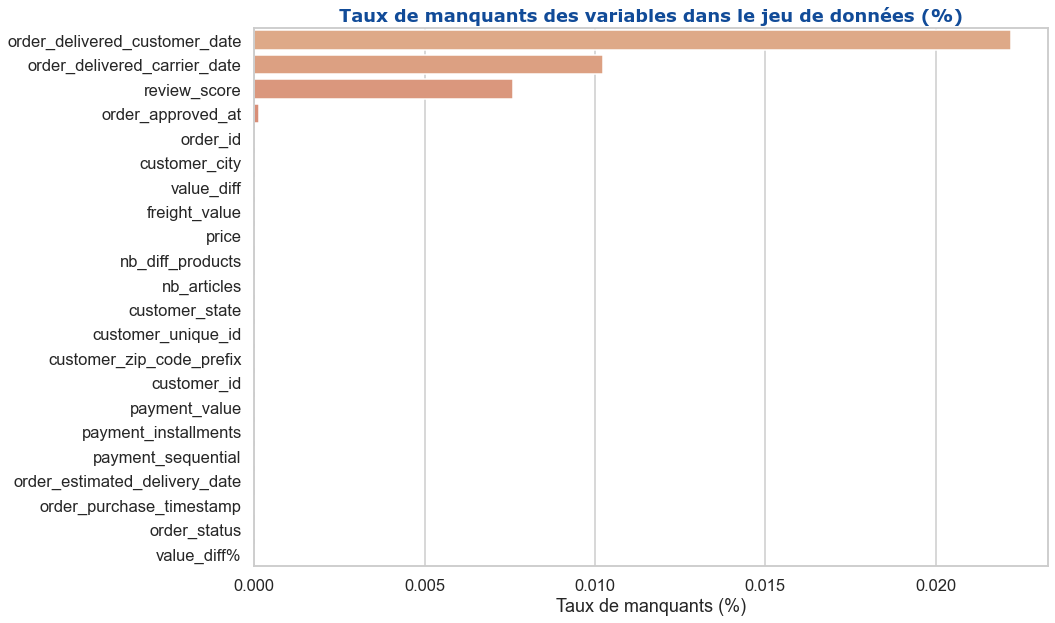

In [724]:
sns.set_context("talk")  # ('notebook', 'paper', 'talk', 'poster')

vars = pd.DataFrame(data.isnull().mean(), columns=['Taux_de_Null']).sort_values(
    by='Taux_de_Null', ascending=False)
fig = plt.figure(figsize=(15, 9))

font_title = {'family': 'verdana',  # serif, arial, verdana, times new roman
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
              }

sns.barplot(x=vars.Taux_de_Null, y=vars.index, data=vars, palette="flare")

# Seuil pour suppression des variables
# plt.axvline(x=max_threshold, linewidth=2, color = 'r')
# plt.text(max_threshold+0.1, 20, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de manquants des variables dans le jeu de données (%)",
          fontdict=font_title)
plt.xlabel("Taux de manquants (%)")

fig.tight_layout()

plt.show()

**Constats et actions sur manquants**
-  NaN principalement concentrés dans les données des **reviews** : ce n'est pas un problème, on les **remplace par 'None'**.
-  les colonnes **order_delivered_customer_date** et **order_delivered_carrier_date** ne seront pas exploitées et donc supprimées.<br>

Pour le reste tout semble complet.

## 4.4 |  Analyse des features utiles à la segmentation

### 4.4.1 | Tri des colonnes utiles

In [725]:
cols_to_keep = ['order_id', 'customer_id', 'order_status',
                'order_purchase_timestamp', 'payment_value', 'customer_unique_id', 'review_score',
                'nb_articles', 'nb_diff_products', 'price', 'freight_value']

In [726]:
data.loc[data['payment_sequential'].isnull(), 'payment_sequential'] = 0

In [727]:
data = data.loc[:, cols_to_keep]

In [728]:
data.loc[data['review_score'].isnull(), 'review_score'] = "None"

In [729]:
data.loc[data['review_score'] != 'None']

,order_id,customer_id,order_status,order_purchase_timestamp,payment_value,customer_unique_id,review_score,nb_articles,nb_diff_products,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,38.71,7c396fd4830fd04220f754e42b4e5bff,4,1,1,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,141.46,af07308b275d755c9edb36a90c618231,4,1,1,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,179.12,3a653a41f6f9fc3d2a113cf8398680e8,5,1,1,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,72.20,7c142cf63193a1473d2e66489a9ae977,5,1,1,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,28.62,72632f0f9dd73dfee390c9b22eb56dd6,5,1,1,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...
98660,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,85.08,6359f309b166b0196dbf7ad2ac62bb5a,5,1,1,72.00,13.08
98661,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,195.00,da62f9e57a76d978d02ab5362c509660,4,1,1,174.90,20.10
98662,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,271.01,737520a9aad80b3fbbdad19b66b37b30,5,1,1,205.99,65.02
98663,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,441.16,5097a5312c8b157bb7be58ae360ef43c,2,2,1,359.98,81.18


In [730]:
data.describe()

,payment_value,nb_articles,nb_diff_products,price,freight_value
count,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000
mean,160.606904,1.141712,1.038099,137.754105,22.823707
std,220.484252,0.538423,0.226458,210.646213,21.650971
min,9.590000,1.000000,1.000000,0.850000,0.000000
25%,62.000000,1.000000,1.000000,45.900000,13.850000
50%,105.290000,1.000000,1.000000,86.900000,17.170000
75%,176.880000,1.000000,1.000000,149.900000,24.040000
max,13664.080000,21.000000,8.000000,13440.000000,1794.960000


In [731]:
data.isnull().mean()

order_id                    0.0
customer_id                 0.0
order_status                0.0
order_purchase_timestamp    0.0
payment_value               0.0
customer_unique_id          0.0
review_score                0.0
nb_articles                 0.0
nb_diff_products            0.0
price                       0.0
freight_value               0.0
dtype: float64

In [732]:
data.shape

(98665, 11)

In [733]:
print('On a maintenant une base de données contenant', data.shape[0],
      'commandes pour un CA de', round(data['payment_value'].sum(), 2), 'Reais, avec :')

On a maintenant une base de données contenant 98665 commandes pour un CA de 15846280.17 Reais, avec :


-  le numéro de commande (order_id)
-  order date (order_purchase_timestamp)
-  order status (pour identifier les annulations)
-  order amounts (payment_value)
-  customer_id et customer_unique_id (clients uniques)
-  review (review_score)
-  nb_articles (numéro d'articles)
-  nb_diff_products (nombre d'articles différents)

Mais cette base est **encore organisée par commande (order_id)**.<br>

Nous allons la transformer afin qu'elle présente la synthèse des **features par customer_unique_id**, pour servir de **base à la segmentation client**.

### 4.4.2 | Vérification des valeurs extrêmes

In [734]:
# Validate if there are any negative values in UnitPrice column
data.describe()

,payment_value,nb_articles,nb_diff_products,price,freight_value
count,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000
mean,160.606904,1.141712,1.038099,137.754105,22.823707
std,220.484252,0.538423,0.226458,210.646213,21.650971
min,9.590000,1.000000,1.000000,0.850000,0.000000
25%,62.000000,1.000000,1.000000,45.900000,13.850000
50%,105.290000,1.000000,1.000000,86.900000,17.170000
75%,176.880000,1.000000,1.000000,149.900000,24.040000
max,13664.080000,21.000000,8.000000,13440.000000,1794.960000


In [735]:
# Check other features
data.describe(include='object')

,order_id,customer_id,order_status,order_purchase_timestamp,customer_unique_id,review_score
count,98665,98665,98665,98665,98665,98665.0
unique,98665,98665,7,98111,95419,12.0
top,775eb0ae1891c8dd8f12c2f8c6850006,aa58e9d75d589687cbb79699e5118e5e,delivered,2018-06-01 13:39:44,8d50f5eadf50201ccdcedfb9e2ac8455,5.0
freq,1,1,96477,3,16,56885.0


### 4.4.3 |  Analyse données qualitatives

In [736]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,payment_value,customer_unique_id,review_score,nb_articles,nb_diff_products,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,38.71,7c396fd4830fd04220f754e42b4e5bff,4,1,1,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,141.46,af07308b275d755c9edb36a90c618231,4,1,1,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,179.12,3a653a41f6f9fc3d2a113cf8398680e8,5,1,1,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,72.20,7c142cf63193a1473d2e66489a9ae977,5,1,1,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,28.62,72632f0f9dd73dfee390c9b22eb56dd6,5,1,1,19.90,8.72


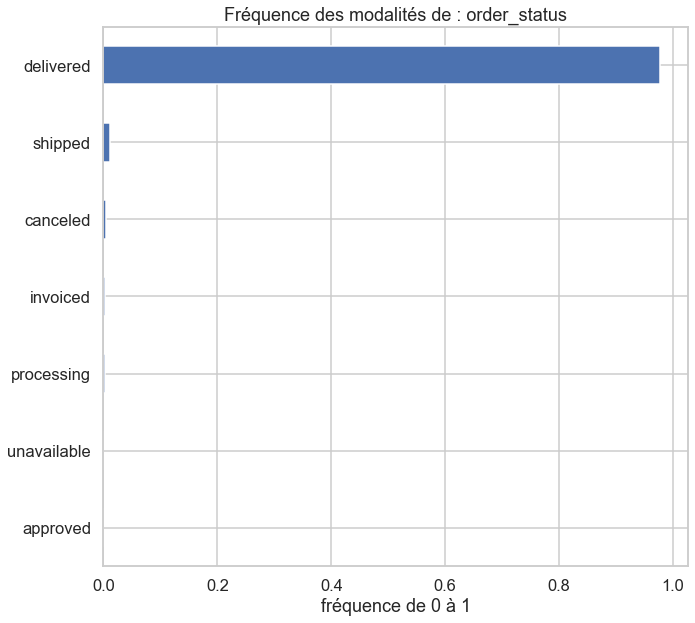

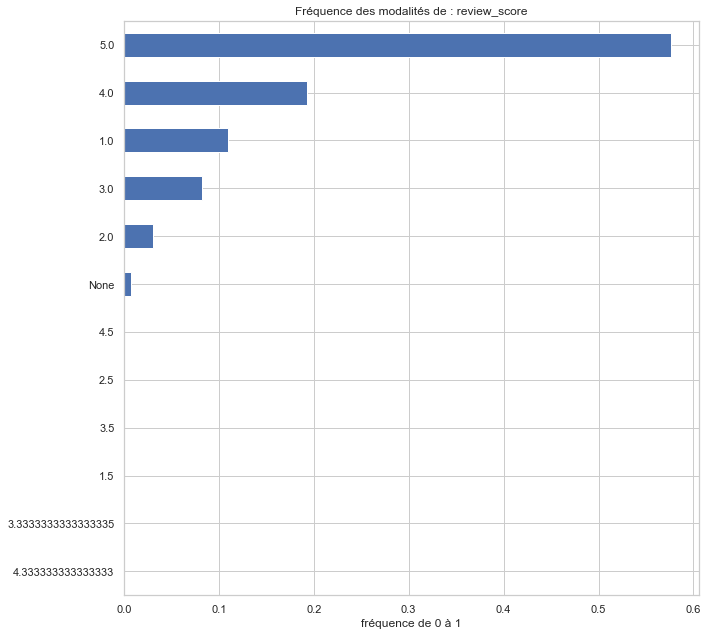

In [737]:
for column in ['order_status', 'review_score']:
    chaine = 'Fréquence des modalités de : ' + column
    plt.figure(figsize=(10, 9))
    data[column].value_counts(normalize=True, ascending=True).plot(
        kind='barh')  # normalize pour avoir les fréquences
    plt.title(chaine)
    plt.xlabel("fréquence de 0 à 1")
    plt.tight_layout()

    # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')
    sns.set_context("notebook")

    plt.show()

**Revues**<br>
Pour les revues, pour près de 80% des commandes le retour est de 4 (20%) ou 5 (60%). 10% de retour minimal (1). Très peu de commandes sans retour. 

**Statut**<br>
La majorité des commandes sont livrées. Les taux d'annulation ou de non disponibles sont faibles. Calculons les :

In [738]:
not_delivered = data.loc[(data['order_status'] == 'canceled') | (
    data['order_status'] == 'unavailable')].shape[0]

print('Le nombre de commandes non livrées - indisponible ou annulée - est de ',
      not_delivered, ".")

Le nombre de commandes non livrées - indisponible ou annulée - est de  467 .


In [739]:
print('Le taux de commandes non livrées - indisponible ou annulée - est de ',
      round(not_delivered/data.shape[0], 3)*100, "%.")

Le taux de commandes non livrées - indisponible ou annulée - est de  0.5 %.


Je décide de conserver ces lignes, car elles peuvent être le signe de clients mécontents par le prix (annulation) ou la prestation (indisponible), et constituer une sous catégorie de la segmentation à terme.

### 4.4.4 |  Analyse données quantitatives

#### 4.4.4.1 | Passage au Log de la variable 'payment_value'

In [740]:
data_log_cols = ['payment_value']

In [741]:
switch_log(data_log_cols)

#### 4.4.4.2 | Distribution 'payment_value' après passage au Log

In [742]:
data_num = ['payment_value', 'payment_value_log']

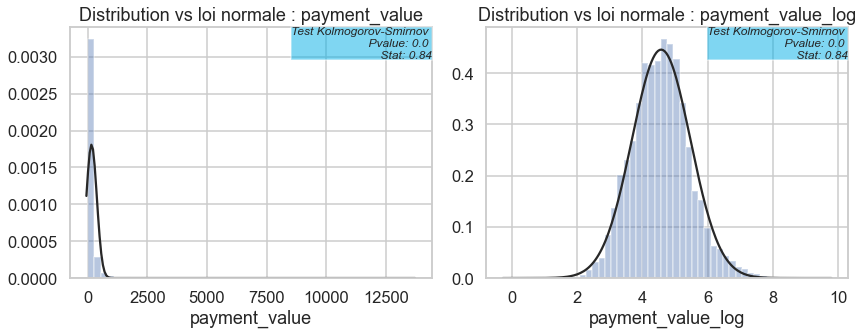

In [743]:
warnings.filterwarnings('ignore')

# scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')
sns.set_context("talk")

sns.set_style("whitegrid")
fig = plt.figure(figsize=(18, 5))

sub = 0
for i in range(len(data_num)):
    fig.add_subplot(len(data_num)//3+1, 3, i+1)

    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height

    colonne = data_num[i]
    kstest = stats.kstest(data[colonne].notnull(), 'norm')
    ax = sns.distplot(data[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    ax.text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'
            .format(kstest.pvalue, kstest.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=ax.transAxes, fontsize=12,
            bbox={'facecolor': '#00afe6', 'alpha': 0.5, 'pad': 0})
    sub += 1

    fig.tight_layout()

plt.show()

We can see that payment_value was skewed on the left, and that the log treatment normalized the curve. 

## 4.5 |  Aggrégation de data par client & critères RFM

Afin d'étudier les **clients uniques** pour les **segmenter**, nous allons transformer le dataframe data (par commande) en un dataframe data avec les mêmes données, mais agrégées par **client unique**.<br>

Nous créerons également les **features nécessaires à l'analyse RFM**: Recency, Frequency, Monetary Value.

Pour cela nous utiliserons la méthode **groupby** associée à un **dictionnaire** précisant les **aggrégations** pour chaque feature.

**Recency** = Latest Purchase Date - Last Purchase Date per customer,<br>
**Frequency** = count of order no. of transaction(s),<br>
**Monetary** = Sum of Total

We take the amount for **each customer**

### 4.5.1 | Champ order_purchase_timestamp : format et identification date la plus récente 

In [744]:
data.order_purchase_timestamp.dtype

dtype('O')

In [745]:
# Convert the string date field to datetime
data['order_purchase_timestamp'] = pd.to_datetime(
    data['order_purchase_timestamp'])

In [746]:
data['order_purchase_timestamp'].max()

Timestamp('2018-09-03 09:06:57')

In [747]:
# Set Latest date 2018-09-04 as last invoice date was 2018-09-03.
# This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2018, 9, 4)

To estimate the **Recency**, we will compare latest purchase date of the dataset with the last date of purchase for each customer. This number of days will represent the relative recency compared with latest purchase made.

### 4.5.2 | Création des scores RFM et autres features pour chaque client

From this dataset data we will now create a RFMScores dataframe in order to present our customer according to the RFM segmentation. 

In [748]:
data.loc[data['review_score'] == 'None']['order_id'].count()

749

Je supprime les commandes sans review score, car ceux-ci seront utilisés plus tard dans la segmentation pour mesurer la satisfaction client.

In [749]:
mask = data['review_score'] == 'None'

In [750]:
before = data.shape[0]

In [751]:
data = data[~mask]

In [752]:
after = data.shape[0]

In [753]:
print(before-after, 'lignes sans review_score ont été supprimées du jeu de données.')

749 lignes sans review_score ont été supprimées du jeu de données.


In [754]:
# Convert the string review_score field to numeric
data['review_score'] = pd.to_numeric(data['review_score'])

We will now **create the dataframe RFMScores** enriched with some **additional features** like :
-  last purchase weekday, 
-  average number of products or 
-  average basket value.<br>

In order to add the recency feature, we just need to use a function that returns the **number of days** since **last purchase**, starting from the **day of the last sale** in the final dataset : **days_latest**. 

In [755]:
RFMScores = data.groupby('customer_unique_id').agg(
    recency=('order_purchase_timestamp', days_latest),
    frequency=('order_id', 'count'),
    monetary=('payment_value', 'sum'),
    satisfaction=('review_score', 'mean'),
    nb_articles=('nb_articles', 'mean'),
    nb_diff_products=('nb_diff_products', 'mean'),
    last_purch=('order_purchase_timestamp', 'max'),
)

In [756]:
# We add the weekday of the last purchase to get an idea of preferred days to buy on the site
RFMScores['day_last_purch'] = RFMScores['last_purch'].apply(
    lambda x: x.day_name())

# We can now remove the timestamp of last purchase, as it won't be useful anymore
RFMScores.drop(columns='last_purch', inplace=True)

In [757]:
# We add an average basket indicator
RFMScores['aver_basket'] = RFMScores.monetary / RFMScores.frequency

### 4.5.3 | Analyse des scores RFM, distributions et création des quantiles

In [758]:
RFMScores.head()

,recency,frequency,monetary,satisfaction,nb_articles,nb_diff_products,day_last_purch,aver_basket
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,5.0,1.0,1.0,Thursday,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4.0,1.0,1.0,Monday,27.19
0000f46a3911fa3c0805444483337064,542,1,86.22,3.0,1.0,1.0,Friday,86.22
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,4.0,1.0,1.0,Thursday,43.62
0004aac84e0df4da2b147fca70cf8255,293,1,196.89,5.0,1.0,1.0,Tuesday,196.89


#### 4.5.3.1 | Distribution de clients selon la récence

In [759]:
# Descriptive Statistics (Recency)
RFMScores.recency.describe()

count    94720.000000
mean       243.338978
std        153.164269
min          0.000000
25%        119.000000
50%        224.000000
75%        353.000000
max        729.000000
Name: recency, dtype: float64

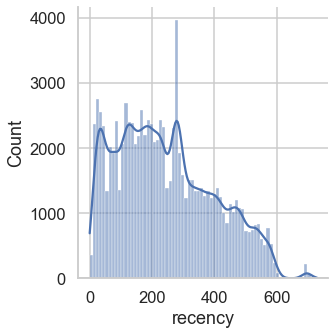

In [760]:
# Recency distribution plot
x = RFMScores['recency']
ax = sns.displot(x, kde=True)

#### 4.5.3.2 | Distribution de clients selon la fréquence d'achat

In [761]:
# Descriptive Statistics (frequency)
RFMScores.frequency.describe()

count    94720.000000
mean         1.033742
std          0.210529
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: frequency, dtype: float64

In [762]:
# Identifying customers with more than 5 purchases
RFMScores[RFMScores['frequency'] > 5]

,recency,frequency,monetary,satisfaction,nb_articles,nb_diff_products,day_last_purch,aver_basket
customer_unique_id,,,,,,,,
12f5d6e1cbf93dafd9dcc19095df0b3d,606,6,110.72,5.000000,1.000000,1.000000,Thursday,18.453333
1b6c7548a2a1f9037c1fd3ddfed95f33,201,7,959.01,5.000000,1.285714,1.285714,Wednesday,137.001429
3e43e6105506432c953e165fb2acf44c,188,9,1172.66,2.777778,1.555556,1.444444,Tuesday,130.295556
47c1a3033b8b77b3ab6e109eb4d5fdf3,222,6,944.21,4.833333,1.166667,1.166667,Wednesday,157.368333
63cfc61cee11cbe306bff5857d00bfe4,98,6,826.32,4.500000,1.833333,1.000000,Monday,137.720000
6469f99c1f9dfae7733b25662e7f1782,67,7,758.83,5.000000,1.285714,1.142857,Thursday,108.404286
8d50f5eadf50201ccdcedfb9e2ac8455,14,16,902.04,5.000000,1.000000,1.000000,Monday,56.377500
ca77025e7201e3b30c44b472ff346268,94,7,1122.72,5.000000,1.714286,1.285714,Friday,160.388571
dc813062e0fc23409cd255f7f53c7074,11,6,1094.63,4.500000,1.833333,1.000000,Thursday,182.438333


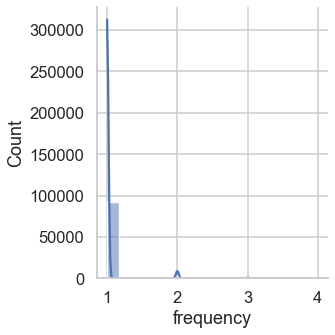

In [763]:
# Frequency distribution plot, taking observations which have frequency less than 5
x = RFMScores.query('frequency < 5')['frequency']
# x = RFMScores['frequency']
ax = sns.displot(x, kde=True)

#### 4.5.3.3 | Distribution de clients selon la valeur monétaire

In [764]:
# Descriptive Statistics (monetary)
RFMScores.monetary.describe()

count    94720.000000
mean       165.778740
std        227.126785
min          9.590000
25%         63.100000
50%        107.850000
75%        182.910000
max      13664.080000
Name: monetary, dtype: float64

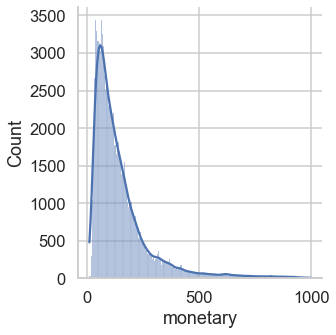

In [765]:
# monetary distribution plot, taking observations which have monetary value less than 1000
x = RFMScores.query('monetary < 1000')['monetary']
ax = sns.displot(x, kde=True)

#### 4.5.3.4 | Distribution de clients selon la satisfaction

In [766]:
# Descriptive Statistics (satisfaction)
RFMScores.satisfaction.describe()

count    94720.000000
mean         4.102521
std          1.326359
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: satisfaction, dtype: float64

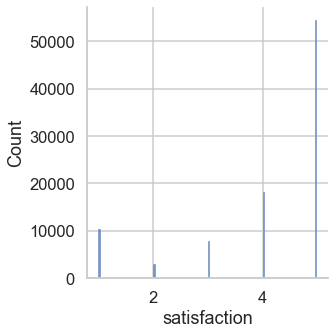

In [767]:
# Satisfaction distribution plot (review score average)
x = RFMScores['satisfaction']
ax = sns.displot(x)

#### 4.5.3.5 | Distribution de clients selon le nombre moyen d'articles achetés

In [768]:
# Descriptive Statistics (nb_articles)
RFMScores.nb_articles.describe()

count    94720.000000
mean         1.138260
std          0.522174
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
Name: nb_articles, dtype: float64

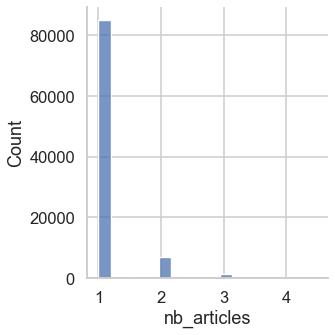

In [769]:
# Items distribution plot (average nb of articles)
x = RFMScores.query('nb_articles < 5')['nb_articles']
ax = sns.displot(x)

#### 4.5.3.6 | Distribution de clients selon le nombre moyen d'articles achetés

In [770]:
# Descriptive Statistics (nb_diff_products)
RFMScores.nb_diff_products.describe()

count    94720.000000
mean         1.036751
std          0.218909
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: nb_diff_products, dtype: float64

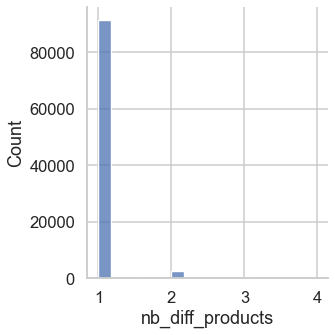

In [771]:
# Items distribution plot (average nb of diff products)
x = RFMScores.query('nb_diff_products < 5')['nb_diff_products']
ax = sns.displot(x)

#### 4.5.3.7 | Distribution de clients selon le jour de la semaine du dernier achat

In [772]:
# Descriptive Statistics (Recency)
RFMScores.day_last_purch.describe()

count      94720
unique         7
top       Monday
freq       15415
Name: day_last_purch, dtype: object

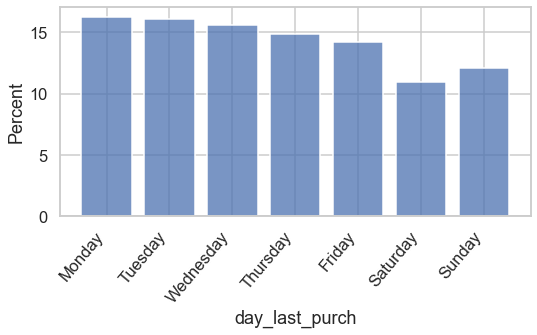

In [773]:
# day_last_purch distribution plot (average nb of items)
x = RFMScores['day_last_purch']

RFMScores['day_last_purch'] = \
    pd.Categorical(RFMScores['day_last_purch'], [
                   'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(8, 5))
g = sns.histplot(data=RFMScores, x='day_last_purch', shrink=0.8,
                 stat="percent", discrete=True, legend=True)
plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout()

#### 4.5.3.8 | Distribution de clients selon le panier moyen

In [774]:
RFMScores['aver_basket'].describe()

count    94720.000000
mean       160.829612
std        219.979710
min          9.590000
25%         62.390000
50%        105.710000
75%        176.980000
max      13664.080000
Name: aver_basket, dtype: float64

Nous retrouvons la notion de **panier moyen cumulé** dans le **dataframe RFMScores** par client avec **'aver_basket'**.<br>
Classons les clients selon une tranche de panier, que nous allons d'abord **transformer en donnée catégorielle**.

In [775]:
# we split the feature in 7 classes from min to max :
RFMScores["aver_basket_cat"] = pd.cut(RFMScores["aver_basket"],
                                      bins=[0, 10, 50, 100, 500,
                                            1000, 10000, np.inf],
                                      labels=['0-10', '10-50', '50-100', '100-500', '500-1000', '1000-10000', '10000-15000'])

In [776]:
RFMScores.head()

,recency,frequency,monetary,satisfaction,nb_articles,nb_diff_products,day_last_purch,aver_basket,aver_basket_cat
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,5.0,1.0,1.0,Thursday,141.90,100-500
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4.0,1.0,1.0,Monday,27.19,10-50
0000f46a3911fa3c0805444483337064,542,1,86.22,3.0,1.0,1.0,Friday,86.22,50-100
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,4.0,1.0,1.0,Thursday,43.62,10-50
0004aac84e0df4da2b147fca70cf8255,293,1,196.89,5.0,1.0,1.0,Tuesday,196.89,100-500


<BarContainer object of 7 artists>

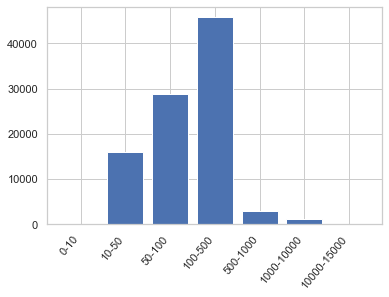

In [777]:
# we plot the distribution by class for the feature in a copy of RFMScores :
RFMScores1 = RFMScores.copy()
RFMScores1.set_index('aver_basket_cat', inplace=True)
cuts_order = ['0-10', '10-50', '50-100', '100-500',
              '500-1000', '1000-10000', '10000-15000']
RFMScores1 = RFMScores1.loc[cuts_order]

plt.tight_layout()
sns.set_context("notebook")  # scaling ('notebook', 'paper', 'talk', 'poster')

to_plot = RFMScores1.index.value_counts(sort=False)
plt.xticks(rotation=50, horizontalalignment='right')
plt.bar(to_plot.index, to_plot.values)

Un panier moyen entre 10 et 500 Reais, plutôt dans la tranche 100-500, et qui chute rapidement juste au-dessus de 500 Reais.

## 4.6 |  Export pickle de RFMScores et data1

In [778]:
data.shape

(97916, 12)

In [779]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,payment_value,customer_unique_id,review_score,nb_articles,nb_diff_products,price,freight_value,payment_value_log
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,38.71,7c396fd4830fd04220f754e42b4e5bff,4.0,1,1,29.99,8.72,3.405189
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,141.46,af07308b275d755c9edb36a90c618231,4.0,1,1,118.70,22.76,4.889371
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,179.12,3a653a41f6f9fc3d2a113cf8398680e8,5.0,1,1,159.90,19.22,5.138911
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,72.20,7c142cf63193a1473d2e66489a9ae977,5.0,1,1,45.00,27.20,4.152771
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,28.62,72632f0f9dd73dfee390c9b22eb56dd6,5.0,1,1,19.90,8.72,2.997231


In [780]:
data.describe()

,payment_value,review_score,nb_articles,nb_diff_products,price,freight_value,payment_value_log
count,97916.000000,97916.000000,97916.000000,97916.000000,97916.000000,97916.000000,97916.000000
mean,160.367686,4.105087,1.140825,1.037900,137.534315,22.804160,4.576750
std,219.286727,1.330286,0.533752,0.225802,209.483686,21.621084,0.894535
min,9.590000,1.000000,1.000000,1.000000,0.850000,0.000000,0.000000
25%,61.930000,4.000000,1.000000,1.000000,45.900000,13.840000,3.976687
50%,105.280000,5.000000,1.000000,1.000000,86.900000,17.160000,4.571510
75%,176.760000,5.000000,1.000000,1.000000,149.900000,24.010000,5.124975
max,13664.080000,5.000000,21.000000,8.000000,13440.000000,1794.960000,9.521897


In [781]:
RFMScores.shape

(94720, 9)

In [782]:
RFMScores.head()

,recency,frequency,monetary,satisfaction,nb_articles,nb_diff_products,day_last_purch,aver_basket,aver_basket_cat
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,5.0,1.0,1.0,Thursday,141.90,100-500
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4.0,1.0,1.0,Monday,27.19,10-50
0000f46a3911fa3c0805444483337064,542,1,86.22,3.0,1.0,1.0,Friday,86.22,50-100
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,4.0,1.0,1.0,Thursday,43.62,10-50
0004aac84e0df4da2b147fca70cf8255,293,1,196.89,5.0,1.0,1.0,Tuesday,196.89,100-500


In [783]:
RFMScores.describe()

,recency,frequency,monetary,satisfaction,nb_articles,nb_diff_products,aver_basket
count,94720.000000,94720.000000,94720.000000,94720.000000,94720.000000,94720.000000,94720.000000
mean,243.338978,1.033742,165.778740,4.102521,1.138260,1.036751,160.829612
std,153.164269,0.210529,227.126785,1.326359,0.522174,0.218909,219.979710
min,0.000000,1.000000,9.590000,1.000000,1.000000,1.000000,9.590000
25%,119.000000,1.000000,63.100000,4.000000,1.000000,1.000000,62.390000
50%,224.000000,1.000000,107.850000,5.000000,1.000000,1.000000,105.710000
75%,353.000000,1.000000,182.910000,5.000000,1.000000,1.000000,176.980000
max,729.000000,16.000000,13664.080000,5.000000,21.000000,8.000000,13664.080000


In [784]:
data.to_pickle("data_raw.pkl")  # cleaned raw data
RFMScores.to_pickle("data1.pkl")  # cleaned data grouped by customer